# Deep Lense Gsoc 2024

---

## Common Task: Multi-class classification

The code is written by Muhammad Mudassir Majeed

The starting date is 24th-March-2024

We will proceed in the following manner


*   Load Model Data
*   EDA on Model Data
*   Data Pre-processing
*   Model Building and Compilation (CNN Most probably)
*   Model fitting and training
*   Model Evaluation (ROC curve and AUC metric)

Please note: that the notebook was run on google colab. The notebook was run on Colab.

## Problem Statement

Build a model for classifying the images into lenses using Keras. We have 3 lense classes.


## Objectives



*   Develop a model for lense classification
*   Evaluate ROC curves and AUC scores for classification task.



## Approach


The best approach for image classification is to utilize already developed state-of-art models for image classification. A variety of models are already available at Keras:

https://keras.io/api/applications/

The idea is to utilize one of the already developed state of the art model and customize is for our needs. Following points are considered when selecting a model:


*   Model should be compatible with our data type
*   Model should be suitable for our task
*   Model should give good results
*   Model should be lightweight for quick and efficient training

### Model Selection
For this classification task, different models were evaluated. We selected 'MobileNetV2'. This is a class of models that are extremely light, fast and produce good results.

The inspiration comes from research article where model was used with custom classifier for classification of grayscale lung radiography images.

**Reference:** https://www.mdpi.com/1424-8220/22/3/1211

The details about model architecture are discussed in later section




---



## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import tensorflow as tf

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.models import load_model

from tensorflow.keras.applications import  MobileNetV2

from skimage.transform import resize

In [2]:
# Load Gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Sub-Programs

Here we define a list of functions and models that are used in this project.

### Model Architectures

As discussed, the inspiration behind model development comes from medical research article for radiography. The model proposed and used in paper is re-imagined with customizations for our use case.

Model requires input images to be of shape (224, 224, 3). We have training images as (150,150,1). Training images are reshaped to match input shape of our model.

The basic model architecture is shown below. Note this model is ammended in classifier part as per need of project.

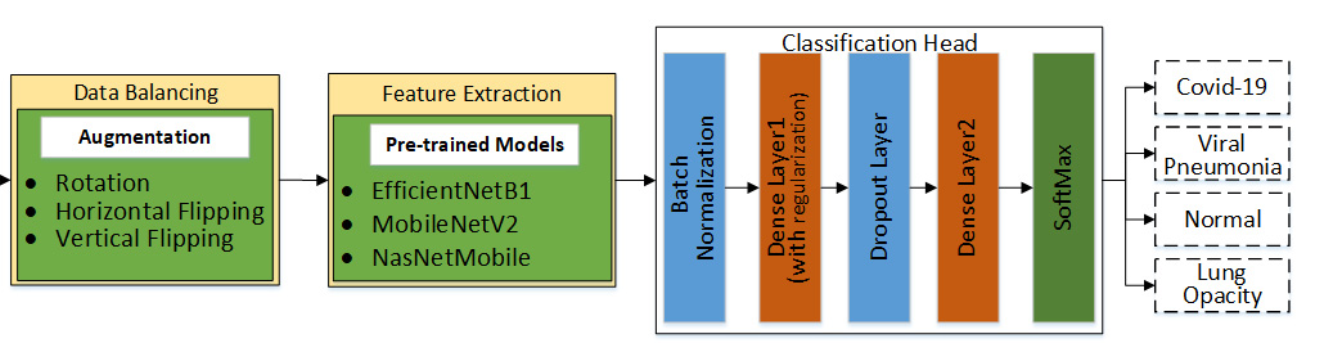

**Model Structure**



- Input Shape: (224,224,3)
- Feature Extraction: MobileNetV2
- Custom Classifier: Dense Layers
  - Batch Normalization
  - Dense Layer 1: 256 units, relu
  - Dense Layer 1: 128 units, relu
  - Dense Layer 2: 3 units, softmax
- Output: 3 class probabilities

Total Trainable Parameters: 2587651




**References:**


*   https://www.mdpi.com/1424-8220/22/3/1211
*   https://www.kaggle.com/code/abdallahwagih/covid-19-classification-efficientnetb0-96-32
*   https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142

In [3]:
def model_MobileNetV2(num_classes, input_shape):

    # Load MobileNetV2 model without top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, pooling = 'avg')

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),

        Dense(256, kernel_regularizer= regularizers.l2(l= 0.01), activity_regularizer= regularizers.l1(0.001),
                bias_regularizer= regularizers.l1(0.001), activation= 'relu'),
        Dropout(0.5),

        Dense(128, kernel_regularizer= regularizers.l2(l= 0.01), activity_regularizer= regularizers.l1(0.001),
        bias_regularizer= regularizers.l1(0.001), activation= 'relu'),

        Dropout(0.3),
        Dense(units = num_classes, activation = 'softmax')
        ])

    return model

### Functions for Processing

This function is used to load .npy image files

In [4]:
# Function to load npy images files
def load_npy_data(data_path):
    iteration_count = 0
    img_data = []
    label_data = []

    class_labels = os.listdir(data_path)

    iteration_count = 0
    # iterate through each class folder
    for class_label in class_labels:
        class_folder = os.path.join(data_path, class_label)
        iteration_count += 1
        print("Processing iteration", iteration_count)

        # iterate through each class file
        for file_name in os.listdir(class_folder):
            if file_name.endswith('.npy'):
                npy_file = os.path.join(class_folder, file_name)
                image = np.load(npy_file)
                label = class_label

                img_data.append(image)
                label_data.append(label)

    # We can convert our lists to numpy arrays
    images = np.array(img_data)
    labels = np.array(label_data)

    shuffle_indices = np.random.permutation(len(images))
    images = images[shuffle_indices]
    labels = labels[shuffle_indices]

    return images, labels

This function is used to plot image samples for EDA

In [5]:
def data_EDA(num_samples, images, labels):
  fig = plt.figure(figsize=(20,5))
  for sample in range(num_samples):
      ax = fig.add_subplot(3, 12, sample + 1, xticks=[], yticks=[])
      image = np.squeeze(images[sample])
      ax.imshow(image, cmap='gray')
      ax.set_title(f"Class: {labels[sample]}", fontsize=12)

This function converts input image from a given dimensions to other dimensions. We use this function to convert training images from (150,150,1) to (224,224,3).

This is necessary since the base model being used for feature extraction (MobileNetV2) requires input images to be in this shape. We can adjust the model to accept inputs of other dimensions. but for now, we are using mentioned approach.

In [6]:
def resize_images_array(grayscale_images, output_shape):

    # Duplicate the single channel to create three channels
    rgb_images = np.concatenate([grayscale_images] * output_shape[2], axis=-1)

    #     # Duplicate the single channel to create three channels
    # rgb_images = np.tile(grayscale_images, (1, 1, 1, new_shape[-1]))

    print("Shape after channels:", rgb_images.shape)
    # Resize the images to (224, 224)
    resized_images = np.zeros((len(grayscale_images), output_shape[0], output_shape[1], output_shape[2]), dtype=np.float32)
    for i in range(len(grayscale_images)):
        resized_images[i] = resize(rgb_images[i], (output_shape[0], output_shape[1]), anti_aliasing=True)

    print("Shape of resized images:", resized_images.shape)

    return resized_images

This function is used to plot training history

In [7]:
# Plot training history curves
def plot_history(history_object,value_1, value_2, label_1, label_2 , title):
    plt.figure(figsize=(5, 5))
    plt.plot(history_object.history[value_1], label= label_1)
    plt.plot(history_object.history[value_2], label= label_2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.show()



---



## Program Code

### Part 1: Load Data
Data is in the form .npy files. We will iterate over each file and store data

The Original train dataset consists of 10000 images for each class in training totaling to 30000 train images

The Original test dataset consists of 2500 images for each class in training totaling to 7500 test images.

Even using colab pro, we run out of memory for RAM and GPU. The train dataset is amended to include first 7000 images from each category

A good alternative would be to handle data more efficiently. We can use data  pipelines or generators. But for now, we just are just reducing the size of train sets.

In [8]:
# Data directory. To run locally, or some other workspace, replace with dataset folder
data_train_path = "/content/gdrive/MyDrive/Gsoc 2024/DeepLense/medium datasets/dataset/train"

In [9]:
with tf.device('/GPU:0'):
  images_train, labels_train = load_npy_data(data_train_path)

Processing iteration 1
Processing iteration 2
Processing iteration 3


In [10]:
print(f'images_train shape: {images_train.shape}')
print(f'labels_train shape: {labels_train.shape}')

images_train shape: (21000, 1, 150, 150)
labels_train shape: (21000,)


### Part 2: EDA for Data

We observe the images to understand better the data that we are dealing with. It helps us better to tackle the problem at hand.

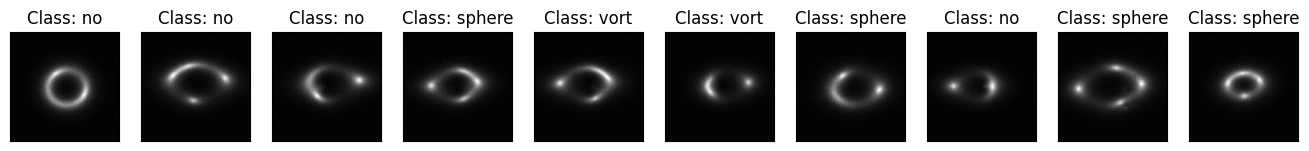

In [11]:
# Part 2: EDA
# Observe image data for better understanding
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, images_train, labels_train)

### Part 3: Pre-processing Data

We will not use any data augmentation techniques. The data is already normalized and other techniques like flipping, rotation etc. are not being explored for this task.

Current image tensors shape: (1, 150, 150)
Desired for Model inputs: (150, 150, 1)

Reshape function below achieves this purpose

In [12]:
# reshape images
images_train = images_train.reshape(-1, 150, 150, 1)

We will use pretrained models with transfer learning for classification tasks. For this our input image size should be (224,224,3)
We will resize our images and increase number of channels to three.


In [13]:
# Resize Images
target_shape = (224,224,3)
with tf.device('/GPU:0'):
  images_train = resize_images_array(images_train, target_shape)

Shape after channels: (21000, 150, 150, 3)
Shape of resized images: (21000, 224, 224, 3)


Observe Images after resizing to ensure images are same as original and we do not have any loss of information

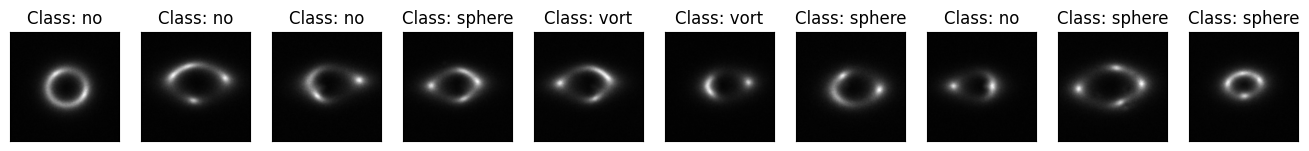

In [14]:
# Observe Image After pre-processing
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, images_train, labels_train)

Encode output labels. We will use one-hot coding for train data.

In [15]:
# Encode categorical values
label_binarizer = LabelBinarizer()
labels_train_onehot = label_binarizer.fit_transform(labels_train)

### Part 4: Develop Model

We developing are model here and defining model parameters.

In [16]:
num_classes = 3
input_shape = (224, 224, 3)

model_Mobile= model_MobileNetV2(num_classes, input_shape)
model_Mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [17]:
# Loss Function
loss_function = 'categorical_crossentropy'

# Optimizer
optimizer = Adam(learning_rate = 0.0001)

# Metrics
Metrics = ['accuracy']

In [18]:
# Compile Model
with tf.device('/GPU:0'):
  model_Mobile.compile(optimizer = optimizer, loss = loss_function , metrics= Metrics)

### Part 5: Train Model

In [19]:
with tf.device('/GPU:0'):
  history = model_Mobile.fit(x=images_train, y=labels_train_onehot, batch_size=20, epochs=9,
                              shuffle=True, verbose=2, validation_split=0.1)

Epoch 1/9
945/945 - 60s - loss: 6.8437 - accuracy: 0.3585 - val_loss: 6.5493 - val_accuracy: 0.3310 - 60s/epoch - 63ms/step
Epoch 2/9
945/945 - 32s - loss: 5.2321 - accuracy: 0.4021 - val_loss: 5.5650 - val_accuracy: 0.3286 - 32s/epoch - 34ms/step
Epoch 3/9
945/945 - 32s - loss: 3.9094 - accuracy: 0.4703 - val_loss: 4.6408 - val_accuracy: 0.3286 - 32s/epoch - 34ms/step
Epoch 4/9
945/945 - 32s - loss: 2.8088 - accuracy: 0.5380 - val_loss: 3.0255 - val_accuracy: 0.4152 - 32s/epoch - 34ms/step
Epoch 5/9
945/945 - 32s - loss: 1.9364 - accuracy: 0.6241 - val_loss: 1.9156 - val_accuracy: 0.5252 - 32s/epoch - 34ms/step
Epoch 6/9
945/945 - 32s - loss: 1.3158 - accuracy: 0.7034 - val_loss: 1.4327 - val_accuracy: 0.5943 - 32s/epoch - 34ms/step
Epoch 7/9
945/945 - 32s - loss: 0.9168 - accuracy: 0.7628 - val_loss: 0.9621 - val_accuracy: 0.6905 - 32s/epoch - 34ms/step
Epoch 8/9
945/945 - 32s - loss: 0.6785 - accuracy: 0.8077 - val_loss: 0.8151 - val_accuracy: 0.7171 - 32s/epoch - 34ms/step
Epoch 9/

From repeated runs, it was observed that model usually starts overfitting after 9 epochs. So training is stopped at 9 epochs.

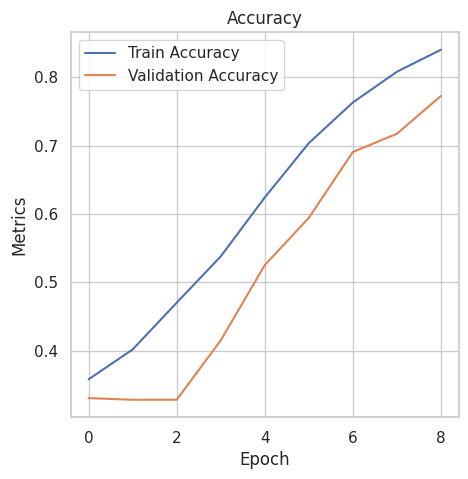

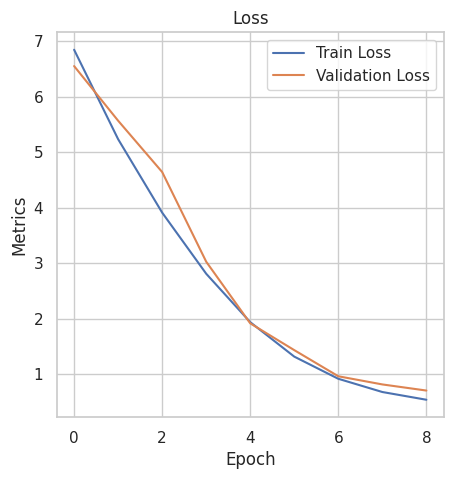

In [20]:
## Loss Curves for train and valid data for observing overfitting.
# Plotting the learning curves for train and validation metrics

# Set seaborn style
sns.set(style="whitegrid")

# Plotting Accuracy
plot_history(history,'accuracy', 'val_accuracy', 'Train Accuracy', 'Validation Accuracy' , 'Accuracy')

# Plotting Loss
plot_history(history,'loss', 'val_loss', 'Train Loss', 'Validation Loss' , 'Loss')

### Part 6: Save Trained Model

Due to limitaions of GPU memory, We will save our trained model here. Referesh our GPU memory and load saved model for predictions

In [21]:
model_Mobile.save('/content/gdrive/MyDrive/Gsoc 2024/DeepLense/Trained Models/Common_Task.keras')

Clear GPU Memory

In [22]:
# Collect garbage
gc.collect()

# Clear TensorFlow session
import tensorflow as tf
tf.keras.backend.clear_session()

# Clear any additional memory allocated by TensorFlow
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Part 7: Evaluate Model
- Predict labels for test images
- Calculate ROC curve and AUC for each class

Load trained Model

In [23]:
loaded_model = load_model('/content/gdrive/MyDrive/Gsoc 2024/DeepLense/Trained Models/Common_Task.keras')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

Load and Process Test data just like input data

In [24]:
data_valid_path = "/content/gdrive/MyDrive/Gsoc 2024/DeepLense/medium datasets/dataset/val"

In [25]:
with tf.device('/GPU:0'):
  images_test, labels_test = load_npy_data(data_valid_path)

Processing iteration 1
Processing iteration 2
Processing iteration 3


In [26]:
print(f'images_test shape: {images_test.shape}')
print(f'labels_test shape: {labels_test.shape}')

images_test shape: (7500, 1, 150, 150)
labels_test shape: (7500,)


Reshape and Resize images so they match the input dimensions required for the model (224, 224, 3)

In [27]:
# Reshape and Resize Images
images_test = images_test.reshape(-1, 150, 150, 1)
# Resize Images
target_shape = (224,224,3)
with tf.device('/GPU:0'):
  images_test = resize_images_array(images_test, target_shape)

Shape after channels: (7500, 150, 150, 3)
Shape of resized images: (7500, 224, 224, 3)


For test we are using Label Encoder because predictions from train model are converted to label encoded data.

In [28]:
# Encode categorical values
label_encoder = LabelEncoder()
labels_test_encode = label_encoder.fit_transform(labels_test)

235/235 [==============================] - 6s 19ms/step


<Figure size 1000x1000 with 0 Axes>

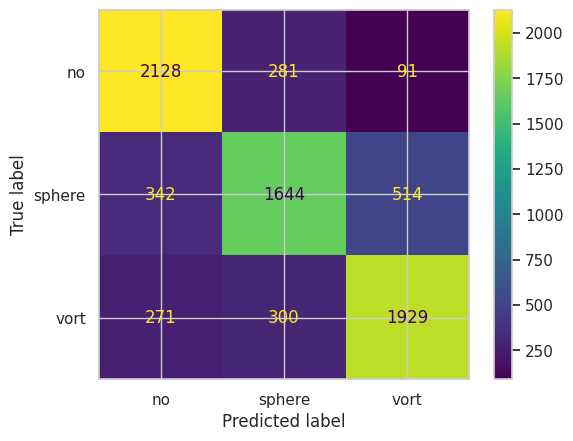

In [29]:
# Plot Confusion Matrix for Each Class
predicted_probabilities = loaded_model.predict(images_test)
predictions=np.argmax(predicted_probabilities, axis=1)
conf_matrix = confusion_matrix(y_true=labels_test_encode, y_pred=predictions)
class_labels = ['no','sphere','vort']

plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= class_labels)
plt.tight_layout(rect=[0, 0.03, 1 , 0.99])
disp.plot()
plt.show()

In [30]:
# Evaluation Values
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
avg_recall = np.mean(recall)
avg_precision = np.mean(precision)
accuracy = accuracy_score(labels_test_encode, predictions)

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

print(f'Model accuracy score is {accuracy:.2%}')
print(f'Model recall score is {avg_recall:.2%}')
print(f'Model precision score is {avg_precision:.2%}')
print(f'Model F1 score is {f1_score:.2%}')


Model accuracy score is 76.01%
Model recall score is 76.01%
Model precision score is 75.88%
Model F1 score is 75.95%


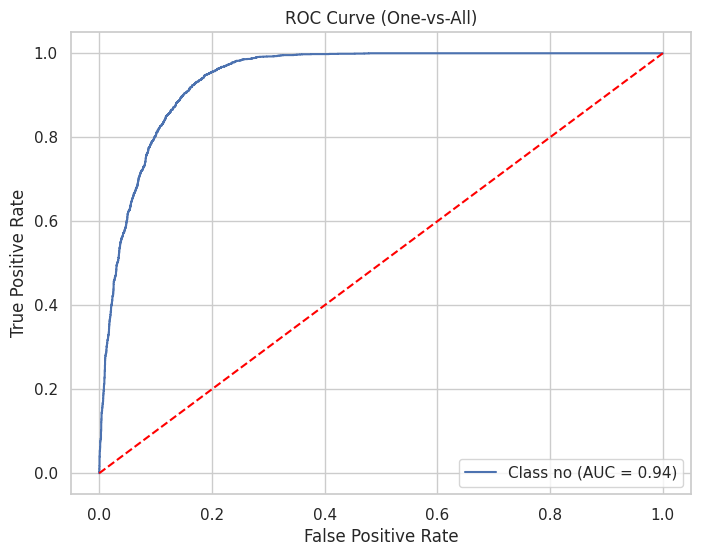

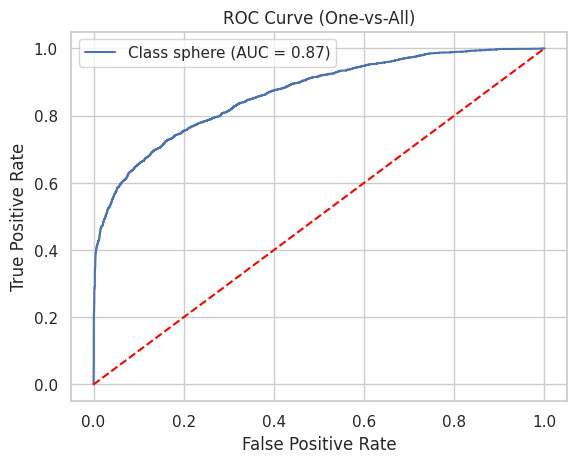

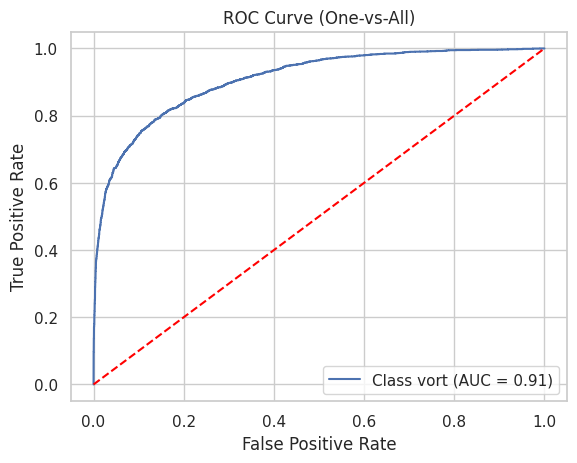

In [31]:
# Plot ROC curve for each class
# Calculate ROC curve and AUC for each class (OvA)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(class_labels):
    # For the ith class, select the corresponding probabilities
    class_probs = predicted_probabilities[:, i]
    # Convert label encoding to binary classification (0 for not class i, 1 for class i)
    binary_labels = (labels_test_encode == i).astype(int)
    # Calculate ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(binary_labels, class_probs)
    roc_auc[i] = roc_auc_score(binary_labels, class_probs)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_label} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-All)')
    plt.legend()
    plt.show()

**Note: Please pre-process test data as mentioned, before testing it using saved model**

In [33]:
"""
def resize_images_array(grayscale_images, output_shape):

    # Duplicate the single channel to create three channels
    rgb_images = np.concatenate([grayscale_images] * output_shape[2], axis=-1)

    #     # Duplicate the single channel to create three channels
    # rgb_images = np.tile(grayscale_images, (1, 1, 1, new_shape[-1]))

    print("Shape after channels:", rgb_images.shape)
    # Resize the images to (224, 224)
    resized_images = np.zeros((len(grayscale_images), output_shape[0], output_shape[1], output_shape[2]), dtype=np.float32)
    for i in range(len(grayscale_images)):
        resized_images[i] = resize(rgb_images[i], (output_shape[0], output_shape[1]), anti_aliasing=True)

    print("Shape of resized images:", resized_images.shape)

    return resized_images

# Reshape and Resize Images
images_test = images_test.reshape(-1, 150, 150, 1)
# Resize Images
target_shape = (224,224,3)
with tf.device('/GPU:0'):
  images_test = resize_images_array(images_test, target_shape)

"""

'\ndef resize_images_array(grayscale_images, output_shape):\n\n    # Duplicate the single channel to create three channels\n    rgb_images = np.concatenate([grayscale_images] * output_shape[2], axis=-1)\n\n    #     # Duplicate the single channel to create three channels\n    # rgb_images = np.tile(grayscale_images, (1, 1, 1, new_shape[-1]))\n\n    print("Shape after channels:", rgb_images.shape)\n    # Resize the images to (224, 224)\n    resized_images = np.zeros((len(grayscale_images), output_shape[0], output_shape[1], output_shape[2]), dtype=np.float32)\n    for i in range(len(grayscale_images)):\n        resized_images[i] = resize(rgb_images[i], (output_shape[0], output_shape[1]), anti_aliasing=True)\n\n    print("Shape of resized images:", resized_images.shape)\n\n    return resized_images\n\n# Reshape and Resize Images\nimages_test = images_test.reshape(-1, 150, 150, 1)\n# Resize Images\ntarget_shape = (224,224,3)\nwith tf.device(\'/GPU:0\'):\n  images_test = resize_images_array

___

## Discussion

The Task of multi-class classification was completed with desirable results. The model usually starts overfitting after 9 epochs. For development of this model, different strategies were tested. These included:
- Developing a Simple Convolution Network.
- Trying different pre-trained networks.
- Adjusting architecture of already trained networks.
- Trying hyper parameter tuning to adjust for overfitting
- fine-tuning with freezing base model layers.
- Data augmentation
- Introduction of Dropout and regularization to combat overfitting

All the mentioned strategies were briefly explored with little improvements in results. The best was the one used. It allowed for quick model training and used least resources.

The results of the model can be improved by careful consideration of the following:
- Model architecture. A custom model could be designed keeping in mind the data at hand. inspiration could be taken from already developed architectures. Attention based vision transformers deserve a special mention in this regard.
- Model hyperparameters tuning can be further explored. A careful and deep dive here could improve model performance.
- Training on complete dataset will give the model more data to learn from. This was not possible here due to memory restrictions. Increasing memory and other memory efficient methods could be explored.

Careful consideration of above issues may lead to better and improved model performance

## Future Work

The discussed improvements may be explored for further model improvement. Also, new and novel techniques are being developed for efficient and accurate results. One such technique utilizes graph convolution. This could be further explored.

**Reference:** https://arxiv.org/abs/2402.00564

We can also explore attention based transformer models for improving our results.

## Conclusion

The Model is a good effort for classification of gravitational lenses. The model could further be improved by considering other model architectures and other pre-trained models, fine-tuning of hyper paramters and training on complete dataset.

---